In [1]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
import os
import rasterio

# Local imports.
from rasopt.Utilities import utils, land_cover_utils

Could not import rascontrol library.


In [2]:
# Sensor location save path.
sensor_savefp = r"C:\Users\ayoun\Documents\rasopt\src\rasopt\Optimize\sensor_locations.csv"

In [3]:
# Plan file directory.
plan_dir = r"C:\Users\ayoun\Box\Research\Flood_Sim_Materials\BayesOpt_Paper\Data\Mannings_Sensitivity"

# Plan file names.
plan_fnames = [
    'Secchia_Panaro.p23_camp0.03.hdf',
    'Secchia_Panaro.p23_camp0.06.hdf',
    'Secchia_Panaro.p23_camp0.09.hdf',
    'Secchia_Panaro.p23_camp0.12.hdf',
    'Secchia_Panaro.p23_camp0.2.hdf',
]

# Plan file paths.
plan_fps = [os.path.join(plan_dir, fname) for fname in plan_fnames]

In [4]:
# HDF5 plan paths.
# Cell coordinate path.
cell_coord_path = 'Geometry/2D Flow Areas/Secchia_Panaro/Cells Center Coordinate'

# Water depths path.
depth_path = ('Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/'
              '2D Flow Areas/Secchia_Panaro/Depth')

In [5]:
# Create depth time series data frames for each plan file. 
depth_dfs = [utils.extract_depths(plan_fp, depth_path, cell_coord_path) for plan_fp in plan_fps]

In [6]:
# Retain cells that reach cutoff depth for all Manning's n cases.
cutoff = 0.5
max_ar = np.zeros((depth_dfs[0].shape[0], len(plan_fnames)))
for i, df in enumerate(depth_dfs):
    depth_ar = df.to_numpy()
    max_depths = np.max(depth_ar[:,2:], axis=1)
    max_ar[:,i] = max_depths
    
# Filter by cutoff.
retain_rows = np.min(max_ar, axis=1) > cutoff
filter_dfs = [df.iloc[retain_rows,:] for df in depth_dfs]

(428, 61)


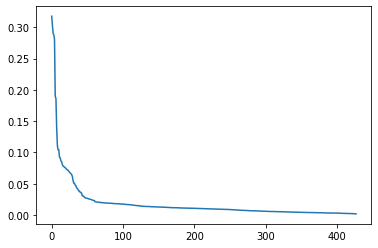

In [7]:
# Compute cell sensitivity based on the average range of the cases.

# Save the lat and lon as a numpy array.
lat_lon = filter_dfs[0].loc[:, ['lat', 'lon']].to_numpy()

# Create array of all cases. Without lat/lon.
case_ar = np.zeros((filter_dfs[0].shape[0], filter_dfs[0].shape[1]-2, len(plan_fnames)))
for i, df in enumerate(filter_dfs):
    depth_ar = df.to_numpy()
    case_ar[:,:,i] = depth_ar[:,2:]
    
# Min and max of 3rd dimension.
case_min = np.min(case_ar, axis=2)
case_max = np.max(case_ar, axis=2)
case_var = np.var(case_ar, axis=2)
print(case_var.shape)

# Range.
case_range = case_max - case_min

# Mean of the range for each row.
case_mean = np.mean(case_var, axis=1)

# Argsort the case variance.
mean_sort_idxs = np.argsort(case_mean)
mean_sort_idxs = np.flip(mean_sort_idxs)

# Plot the variance.
fig, ax = plt.subplots()
ax.plot(case_mean[mean_sort_idxs])

(61, 5)


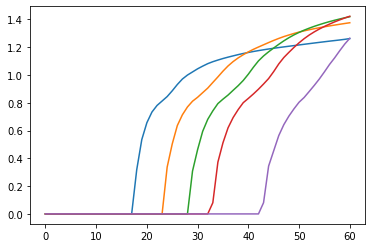

In [16]:
# Test plots of highly variant cells.
test_cell = 20
cell_idx = mean_sort_idxs[test_cell]

# Depths from each case.
cell_depths = case_ar[cell_idx,:,:]
print(cell_depths.shape)

fig, ax = plt.subplots()
ax.plot(cell_depths)

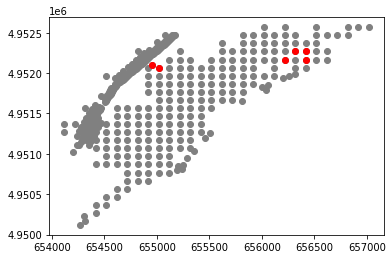

In [17]:
# Get lat and lon from the sensitive cells.
start_cell = 0
end_cell = 6
cell_lat_lon = lat_lon[mean_sort_idxs[start_cell:end_cell],:]

fig, ax = plt.subplots()
ax.scatter(lat_lon[:,1], lat_lon[:,0], c='gray')
ax.scatter(cell_lat_lon[:,1], cell_lat_lon[:,0], c='red')

In [18]:
# Save a certain subset of the highly sensitive sensor locations.
idx_subset = mean_sort_idxs[start_cell:end_cell]
subset_lat_lon = lat_lon[idx_subset,:]
np.savetxt(sensor_savefp, subset_lat_lon, 
              delimiter = ",")